In [1]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
#import gym_pygame

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
env_id = "CartPole-v1"
env = gym.make(env_id)
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [-2.4969738e+00 -4.9540597e+37  3.4883544e-01  1.6825843e+38]


In [5]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 1


In [13]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [8]:
Hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.99,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [9]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0
        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

In [10]:
import numpy as np
from tqdm import tqdm

def evaluate_regret(policy, eval_env, n_eval_episodes, max_steps):
    """
    Evaluate the policy and calculate the regret.
    Regret is defined as the difference between the maximum possible return
    and the actual return obtained by the policy.
    """
    max_possible_return = n_eval_episodes * max_steps
    mean_reward, _ = evaluate_agent(eval_env, max_steps, n_eval_episodes, policy)
    regret = max_possible_return - mean_reward
    return regret

def tune_hyperparameters(env_id, state_size, action_size, n_training_episodes, max_steps, n_eval_episodes):
    """
    Tune the hyperparameters of the REINFORCE algorithm to minimize the regret.
    """
    best_regret = float('inf')
    best_hyperparams = None

    # Define the hyperparameter search space
    learning_rates = [1e-4, 1e-3, 1e-2]

    for lr in tqdm(learning_rates, desc="Tuning hyperparameters"):
                hyperparams = {
                    "h_size": 16,
                    "n_training_episodes": n_training_episodes,
                    "n_evaluation_episodes": n_eval_episodes,
                    "max_t": max_steps,
                    "gamma": 0.99,
                    "lr": lr,
                    "env_id": env_id,
                    "state_space": state_size,
                    "action_space": action_size,
                }

                policy = Policy(hyperparams["state_space"], hyperparams["action_space"], hyperparams["h_size"]).to(device)
                optimizer = optim.Adam(policy.parameters(), lr=hyperparams["lr"])

                regret = evaluate_regret(policy, env, n_eval_episodes, max_steps)

                if regret < best_regret:
                    best_regret = regret
                    best_hyperparams = hyperparams

    return best_hyperparams, best_regret

# Call the hyperparameter tuning function
best_hyperparams, best_regret = tune_hyperparameters(
    env_id=env_id,
    state_size=s_size,
    action_size=a_size,
    n_training_episodes=100,
    max_steps=1000,
    n_eval_episodes=10
)

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best regret: {best_regret:.2f}")

Tuning hyperparameters:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Tuning hyperparameters: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Best hyperparameters: {'h_size': 16, 'n_training_episodes': 100, 'n_evaluation_episodes': 10, 'max_t': 1000, 'gamma': 0.99, 'lr': 0.01, 'env_id': 'CartPole-v1', 'state_space': 4, 'action_space': 2}
Best regret: 9972.80


In [16]:
def run_reinforce(num_seeds=5):
    all_scores = []
    for seed in range(num_seeds):
        np.random.seed(seed)
        torch.manual_seed(seed)

        policy = Policy(Hyperparameters["state_space"], Hyperparameters["action_space"], Hyperparameters["h_size"]).to(device)
        Optimizer = optim.Adam(policy.parameters(), lr= best_hyperparams["lr"])

        scores = reinforce(policy, Optimizer, Hyperparameters["n_training_episodes"], Hyperparameters["max_t"], Hyperparameters["gamma"], 100)
        all_scores.append(scores)

    all_scores = np.array(all_scores)
    mean_scores = np.mean(all_scores, axis=0)
    std_scores = np.std(all_scores, axis=0)
    return mean_scores, std_scores

mean_scores, std_scores = run_reinforce()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100	Average Score: 96.14
Episode 200	Average Score: 284.15
Episode 300	Average Score: 283.27
Episode 400	Average Score: 470.10
Episode 500	Average Score: 425.08
Episode 600	Average Score: 489.62
Episode 700	Average Score: 467.60
Episode 800	Average Score: 495.76
Episode 900	Average Score: 495.88
Episode 1000	Average Score: 422.97
Episode 100	Average Score: 165.52
Episode 200	Average Score: 359.83
Episode 300	Average Score: 440.56
Episode 400	Average Score: 358.59
Episode 500	Average Score: 486.61
Episode 600	Average Score: 479.70
Episode 700	Average Score: 471.01
Episode 800	Average Score: 497.67
Episode 900	Average Score: 495.93
Episode 1000	Average Score: 500.00
Episode 100	Average Score: 33.74
Episode 200	Average Score: 104.56
Episode 300	Average Score: 271.77
Episode 400	Average Score: 383.53
Episode 500	Average Score: 214.43
Episode 600	Average Score: 471.23
Episode 700	Average Score: 484.92
Episode 800	Average Score: 471.56
Episode 900	Average Score: 486.06
Episode 1000	A

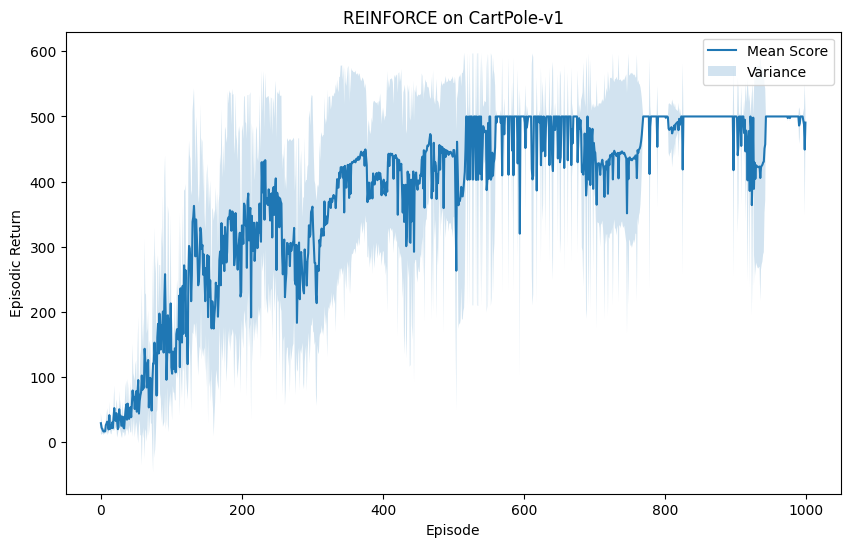

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_scores)), mean_scores, label='Mean Score')
plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, label='Variance')
plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.title('REINFORCE on CartPole-v1')
plt.legend()
plt.show()